In [1]:
%pip install numpy pandas scikit-learn scipy matplotlib seaborn openpyxl


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import sklearn
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from IPython.core.display import display, HTML
import seaborn as sns
import sys
import os

/tmp/ipykernel_546527/2947062357.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [16]:
#Base de Datos NONAN: Noraxon Ultium MotionTM inertial measurement unit (IMU) sensors sampled the motion
#of 35 healthy young adults (19–35 years old; 18 men and 17 women; mean ± 1 s.d. age: 24.6 ± 2.7 years;
#height: 1.73 ± 0.78 m; body mass: 72.44 ± 15.04 kg) over 18 4-min trials across two days 
#480001 data length and 200 Hz sampling rate = 240 seconds or 4 min per trial

sampling_rate = 200

# Nombre del archivo CSV en el mismo directorio que el script
nombre_archivo = 'young adults (19–35 years old)/S002/S002_G01_D01_B03_T02.csv'
#nombre_archivo = 'old adults (56+ years old)/S112/S112_G03_D01_B01_T01.csv'

# Leer el archivo CSV
file_path = os.path.join(os.getcwd(), nombre_archivo)
dat = pd.read_csv(file_path)
df = pd.DataFrame(dat)
# Mostrar las primeras filas del archivo para verificar
#print(dat.head())

In [3]:
from SpatioTemporal_calculation import compute_spatiotemporal_variables
from gait_events import gait_events_HC_JA

In [11]:
heel_strike_R, heel_strike_L, toe_off_R, toe_off_L = gait_events_HC_JA(df)


In [5]:
print(f"heel_strike_R: {len(heel_strike_R)}")
print(f"heel_strike_L: {len(heel_strike_L)}")
print(f"toe_off_R: {len(toe_off_R)}")
print(f"toe_off_L: {len(toe_off_L)}")

heel_strike_R: 221
heel_strike_L: 218
toe_off_R: 217
toe_off_L: 216


In [ ]:
spatiotemporal_df, mean_df, std_df = compute_spatiotemporal_variables(df, heel_strike_R, heel_strike_L, toe_off_R, toe_off_L, sampling_rate)

In [8]:
mean_df=mean_df.T
print(mean_df)

                                        0
Right Step Width (cm)           14.210105
Left Step Width (cm)            15.372882
Right Stride Length (cm)       149.234928
Left Stride Length (cm)        149.188950
Right Step Length (cm)          72.989047
Left Step Length (cm)           72.953815
Right Stride Time (s)            1.205783
Left Stride Time (s)             1.209899
Right Step Time (s)              0.608712
Left Step Time (s)               0.608712
Right Stance Time (s)            0.572172
Right Swing Time (s)             0.633611
Left Swing Time (s)              0.657576
Left Stance Time (s)             0.552323
Double Support Time (s)          0.290355
Single Support Time (s)          0.915254
Percentage Double Support (%)   24.315115
Percentage Single Support (%)   75.684885
Left Percentage Stance (%)      45.638073
Left Percentage Swing (%)       54.361927
Right Percentage Stance (%)     47.585553
Right Percentage Swing (%)      52.414447
Left Stride Speed (m/s)          1

In [4]:
from gait_events import gait_events_HC_JA
heel_strike_R, toe_off_R, heel_strike_L, toe_off_L, contact_L, contact_R = gait_events_HC_JA(df)
# Crear un diccionario con los eventos de marcha
gait_events_dict = {
    "Heel Strike Right": heel_strike_R,
    "Toe Off Right": toe_off_R,
    "Heel Strike Left": heel_strike_L,
    "Toe Off Left": toe_off_L
}

# Crear un DataFrame a partir del diccionario
gait_events_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in gait_events_dict.items()]))


In [ ]:
gait_events_df

<h1><b>SPATIOTEMPORAL VARIABLES</b></h1>

In [ ]:
#To check the contact LT and RT columns
import pandas as pd
import tkinter as tk
from tkinter import ttk


# Extraer las columnas deseadas y las primeras 200 filas
try:
    df_contact = dat[["Contact LT", "Contact RT"]].head(200)
except KeyError as e:
    print(f"Columnas no encontradas: {e}")

# Crear la ventana de Tkinter
root = tk.Tk()
root.title("Contact LT y Contact RT")
root.geometry("400x400")

# Crear el frame para la tabla con scroll
frame = tk.Frame(root)
frame.pack(fill=tk.BOTH, expand=True)

# Crear el scrollbar
scrollbar = tk.Scrollbar(frame)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

# Crear la tabla
tree = ttk.Treeview(frame, columns=("Contact LT", "Contact RT"), show="headings")

# Configurar encabezados
tree.heading("Contact LT", text="Contact LT")
tree.heading("Contact RT", text="Contact RT")

# Ajustar el scrollbar
tree.config(yscrollcommand=scrollbar.set)
scrollbar.config(command=tree.yview)

# Insertar los datos en la tabla
if 'df_contact' in locals():
    for _, row in df_contact.iterrows():
        tree.insert("", tk.END, values=(row["Contact LT"], row["Contact RT"]))

# Empaquetar la tabla
tree.pack(fill=tk.BOTH, expand=True)

# Ejecutar la aplicación
root.mainloop()

In [17]:
#Gait events identification using joint angles
#Detecting Heel Strikes (HS) and Toe-Offs (TO) using joint angles (knee and hip) instead of contact sensors.

def detect_gait_events_using_joint_angles_and_contact(file_path):
    """
    Detects Heel Strikes (HS) and Toe-Offs (TO) using knee and hip angles and contact information.
    """
    # Load dataset
    df = pd.read_csv(file_path)

    # Extract required joint angles
    knee_flex_R = df["Knee Flexion RT (deg)"].values
    knee_flex_L = df["Knee Flexion LT (deg)"].values
    hip_flex_R = df["Hip Flexion RT (deg)"].values
    hip_flex_L = df["Hip Flexion LT (deg)"].values
    time = df["time"].values
    
    # Extract contact information (Contact LT and Contact RT)
    contact_R = df["Contact RT"].values  # Right foot contact
    contact_L = df["Contact LT"].values  # Left foot contact

    # Detect Heel Strikes (HS) - Knee extension peaks & hip flexion maximum
    hip_flex_threshold = 10  # Degrees (hip flexion threshold for validating HS)

    # Detect Heel Strikes (HS) - Knee extension peaks
    heel_strike_R, _ = find_peaks(knee_flex_R)  # Right knee extension peak
    heel_strike_L, _ = find_peaks(knee_flex_L)  # Left knee extension peak

    # Filter by hip flexion (only accept if hip is flexed beyond threshold)
    heel_strike_R = [i for i in heel_strike_R if hip_flex_R[i] > hip_flex_threshold]
    heel_strike_L = [i for i in heel_strike_L if hip_flex_L[i] > hip_flex_threshold]

    # Filter by Contact information (only consider if contact is made - contact == 1000)
    heel_strike_R = [i for i in heel_strike_R if contact_R[i] == 1000]
    heel_strike_L = [i for i in heel_strike_L if contact_L[i] == 1000]

    # Toe-Off Detection - Knee flexion velocity and hip acceleration peaks
    knee_vel_R = np.gradient(knee_flex_R, time)  # Right knee velocity
    knee_vel_L = np.gradient(knee_flex_L, time)  # Left knee velocity

    # Compute Hip Acceleration (Second Derivative of Hip Flexion)
    hip_vel_R = np.gradient(hip_flex_R, time)  # Right hip velocity
    hip_vel_L = np.gradient(hip_flex_L, time)  # Left hip velocity
    hip_acc_R = np.gradient(hip_vel_R, time)  # Right hip acceleration
    hip_acc_L = np.gradient(hip_vel_L, time)  # Left hip acceleration

    # Detect peaks in knee velocity (possible toe-offs)
    vel_peaks_R, _ = find_peaks(knee_vel_R, distance=30)  # Right knee velocity peaks
    vel_peaks_L, _ = find_peaks(knee_vel_L, distance=30)  # Left knee velocity peaks

    # Select the highest knee velocity peak within each gait cycle and validate with hip acceleration
    toe_off_R = []
    toe_off_L = []

    for i in range(len(heel_strike_R) - 1):
        cycle_peaks = [p for p in vel_peaks_R if heel_strike_R[i] < p < heel_strike_R[i + 1]]
        if cycle_peaks:
            max_peak = max(cycle_peaks, key=lambda p: knee_vel_R[p])
            # Validate Toe-Off with Hip Acceleration (must be positive, indicating forward motion)
            if hip_acc_R[max_peak] > 0:
                toe_off_R.append(max_peak)

    for i in range(len(heel_strike_L) - 1):
        cycle_peaks = [p for p in vel_peaks_L if heel_strike_L[i] < p < heel_strike_L[i + 1]]
        if cycle_peaks:
            max_peak = max(cycle_peaks, key=lambda p: knee_vel_L[p])
            if hip_acc_L[max_peak] > 0:
                toe_off_L.append(max_peak)

    # Return detected gait events
    return heel_strike_R, heel_strike_L, toe_off_R, toe_off_L



In [18]:
heel_strike_R, heel_strike_L, toe_off_R, toe_off_L = detect_gait_events_using_joint_angles_and_contact(file_path)

# Display detected events
detected_events = {
    "Right Heel Strikes": len(heel_strike_R),
    "Left Heel Strikes": len(heel_strike_L),
    "Right Toe-Offs": len(toe_off_R),
    "Left Toe-Offs": len(toe_off_L),
}

# Convert detected events into a DataFrame for visualization
events_df = pd.DataFrame(list(detected_events.items()), columns=["Event Type", "Count"])
print(events_df)

           Event Type  Count
0  Right Heel Strikes    195
1   Left Heel Strikes    196
2      Right Toe-Offs    194
3       Left Toe-Offs    195


In [24]:
def cycle_lengths_from_gait_events(df):
    heel_strike_R, heel_strike_L, toe_off_R, toe_off_L = detect_gait_events_using_joint_angles_and_contact(df)
    # Usamos los eventos de heel_strike_R para definir los ciclos
    cycles = []
    for i in range(len(heel_strike_R) - 1):
        start = heel_strike_R[i]
        end = heel_strike_R[i + 1]
        length = end - start
        cycles.append({'cycle': i+1, 'start': start, 'end': end, 'length': length})
    return pd.DataFrame(cycles)

# Uso:
# df_cycles = cycle_lengths_from_gait_events(df_trial)
# print(df_cycles)

In [26]:
df_cycles = cycle_lengths_from_gait_events(file_path)
print(df_cycles)

     cycle  start    end  length
0        1    306    551     245
1        2    551    785     234
2        3    785   1025     240
3        4   1025   1266     241
4        5   1266   1506     240
..     ...    ...    ...     ...
189    190  46608  46859     251
190    191  46859  47113     254
191    192  47113  47366     253
192    193  47366  47617     251
193    194  47617  47869     252

[194 rows x 4 columns]


In [19]:
#Plot the gait events on the joint angle data
def plot_gait_events(df, heel_strike_R, heel_strike_L, toe_off_R, toe_off_L, start_time, duration):
    """
    Plots knee and hip flexion angles separately for each leg over the first 'time_limit' seconds,
    with markers for detected heel strikes and toe-offs.
    """
    # Extract time and joint angles
    time = df["time"].values
    knee_flex_R = df["Knee Flexion RT (deg)"].values
    knee_flex_L = df["Knee Flexion LT (deg)"].values
    hip_flex_R = df["Hip Flexion RT (deg)"].values
    hip_flex_L = df["Hip Flexion LT (deg)"].values

    # Define the end time
    end_time = start_time + duration

    # Limit the data to the first 'time_limit' seconds
    time_mask = (time >= start_time) & (time <= end_time)
    time = time[time_mask]
    knee_flex_R = knee_flex_R[time_mask]
    knee_flex_L = knee_flex_L[time_mask]
    hip_flex_R = hip_flex_R[time_mask]
    hip_flex_L = hip_flex_L[time_mask]

     # Filter gait events within the selected time window
    heel_strike_R = [i for i in heel_strike_R if start_time <= df["time"].iloc[i] <= end_time]
    heel_strike_L = [i for i in heel_strike_L if start_time <= df["time"].iloc[i] <= end_time]
    toe_off_R = [i for i in toe_off_R if start_time <= df["time"].iloc[i] <= end_time]
    toe_off_L = [i for i in toe_off_L if start_time <= df["time"].iloc[i] <= end_time]

    # Create figure with two subplots (one for each leg)
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Right Leg Plot
    axes[0].plot(time, knee_flex_R, label="Right Knee Flexion", color="blue", alpha=0.7)
    axes[0].plot(time, hip_flex_R, label="Right Hip Flexion", color="green", alpha=0.7)
    axes[0].scatter(df["time"].iloc[heel_strike_R], df["Knee Flexion RT (deg)"].iloc[heel_strike_R], 
                    color="red", label="Right Heel Strike", marker="o")
    axes[0].scatter(df["time"].iloc[toe_off_R], df["Knee Flexion RT (deg)"].iloc[toe_off_R], 
                    color="purple", label="Right Toe-Off", marker="x")
    axes[0].set_ylabel("Angle (degrees)")
    axes[0].set_title(f"Right Leg Gait Events ({start_time}-{end_time} s)")
    axes[0].legend()
    axes[0].grid()

    # Left Leg Plot
    axes[1].plot(time, knee_flex_L, label="Left Knee Flexion", color="orange", alpha=0.7)
    axes[1].plot(time, hip_flex_L, label="Left Hip Flexion", color="brown", alpha=0.7)
    axes[1].scatter(df["time"].iloc[heel_strike_L], df["Knee Flexion LT (deg)"].iloc[heel_strike_L], 
                    color="red", label="Left Heel Strike", marker="o")
    axes[1].scatter(df["time"].iloc[toe_off_L], df["Knee Flexion LT (deg)"].iloc[toe_off_L], 
                    color="purple", label="Left Toe-Off", marker="x")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Angle (degrees)")
    axes[1].set_title(f"Left Leg Gait Events ({start_time}-{end_time} s)")
    axes[1].legend()
    axes[1].grid()

    # Show the plot
    plt.show()

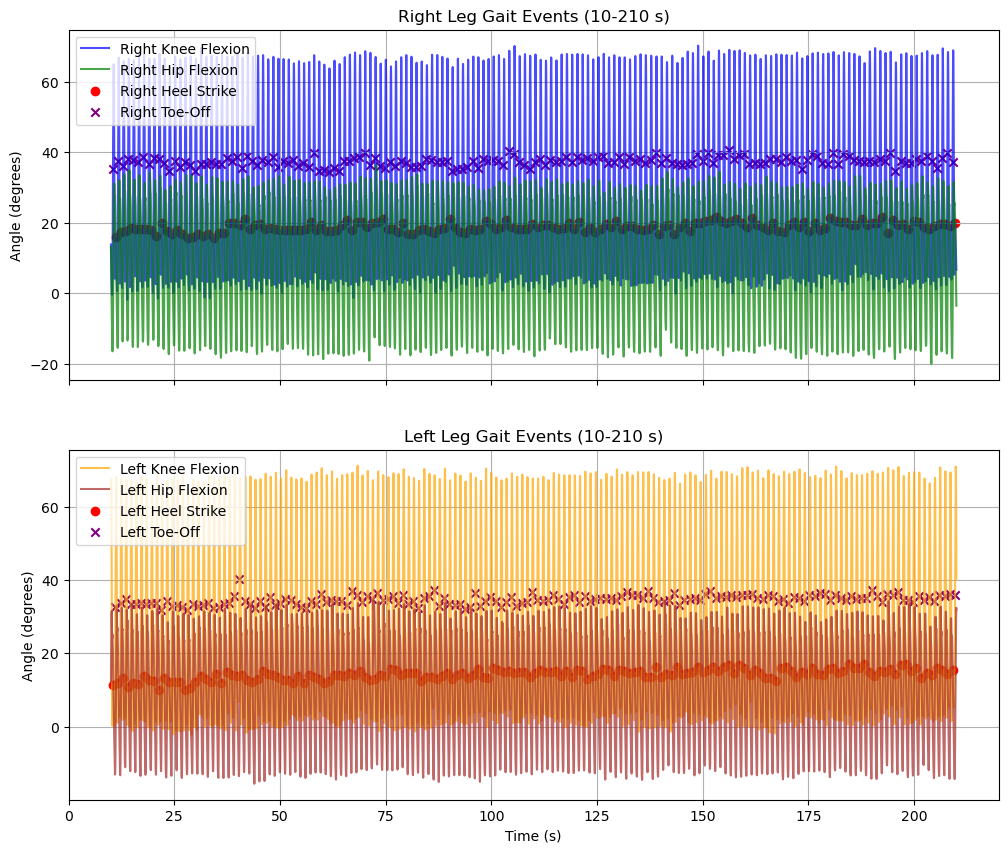

In [20]:
plot_gait_events(df, heel_strike_R, heel_strike_L, toe_off_R, toe_off_L,start_time=10, duration=200)


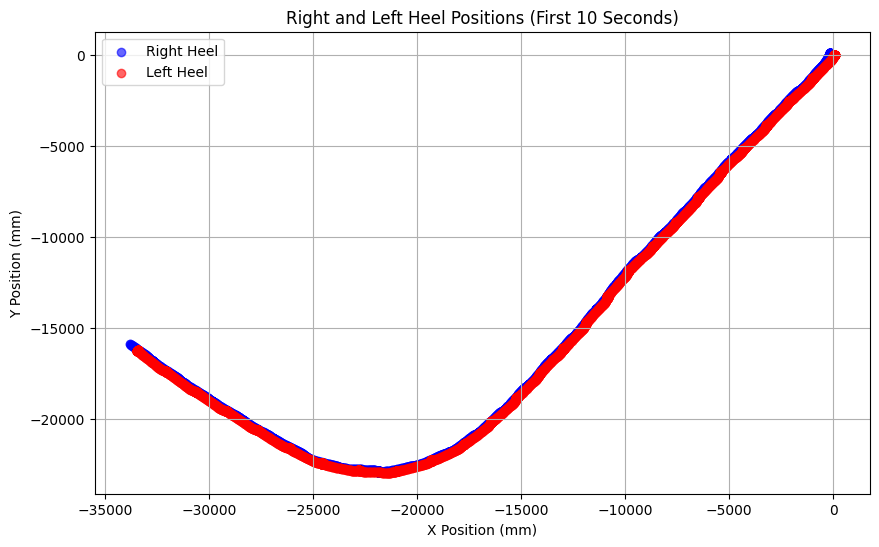

In [ ]:
#plot the heel positions for the first 200 samples
# Plot the x and y coordinates of the right and left heels
import matplotlib.pyplot as plt

# Assuming the "time" column exists in your dataframe to filter the first 10 seconds
time = df["time"].values # Assuming the time column is named "time"
time_limit = 30  # First 10 seconds

# Get the indices for the first 10 seconds
time_filtered = df[time <= time_limit]

# Get corresponding x and y positions for both right and left heels for the first 10 seconds
heel_R_x_filtered = time_filtered["Noraxon MyoMotion-Trajectories-Heel RT-x (mm)"]
heel_R_y_filtered = time_filtered["Noraxon MyoMotion-Trajectories-Heel RT-y (mm)"]
heel_L_x_filtered = time_filtered["Noraxon MyoMotion-Trajectories-Heel LT-x (mm)"]
heel_L_y_filtered = time_filtered["Noraxon MyoMotion-Trajectories-Heel LT-y (mm)"]

# Create a plot to show the x and y coordinates for both heels (first 10 seconds)
plt.figure(figsize=(10, 6))

# Plot right heel positions (x, y)
plt.scatter(heel_R_x_filtered, heel_R_y_filtered, label="Right Heel", color='b', alpha=0.6)

# Plot left heel positions (x, y)
plt.scatter(heel_L_x_filtered, heel_L_y_filtered, label="Left Heel", color='r', alpha=0.6)

# Add labels and title
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Right and Left Heel Positions (First 10 Seconds)')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [65]:
#To calculate left step width and length and stride length
def compute_L_step_width_and_length(df, heel_strike_R, heel_strike_L):
    """
    Compute step width and step length using Heron's formula, based on the right and left foot heel strike locations.
    """
    # Extracting right and left foot positions (x and y)
    rightXTraj = df["Noraxon MyoMotion-Trajectories-Heel RT-x (mm)"].values
    rightYTraj = df["Noraxon MyoMotion-Trajectories-Heel RT-y (mm)"].values
    leftXTraj = df["Noraxon MyoMotion-Trajectories-Heel LT-x (mm)"].values
    leftYTraj = df["Noraxon MyoMotion-Trajectories-Heel LT-y (mm)"].values
    
    time= df["time"].values

    # Initialize arrays to store results
    right_stride_length = []
    right_stride_time = []
    left_step_width = []
    left_step_length = []
    left_step_time = []
    left_swing_time = []
    left_stance_time = []
    
    # Loop over the heel strike locations to compute stride lengths, step width, and step length
    for i in range(len(heel_strike_R) - 1):
        # Get the foot locations for the current and next step
        R_idx = heel_strike_R[i]
        L_idx = heel_strike_L[i]
        
        # Get x and y coordinates of right and left foot
        R1x = rightXTraj[R_idx]
        R1y = rightYTraj[R_idx]
        R2x = rightXTraj[heel_strike_R[i + 1]]
        R2y = rightYTraj[heel_strike_R[i + 1]]
        L1x = leftXTraj[L_idx]
        L1y = leftYTraj[L_idx]
        
        # Calculate right stride length (distance from right foot in step 1 to right foot in step 2)
        right_stride = np.sqrt((R2x - R1x)**2 + (R2y - R1y)**2)
        right_stride_length.append(right_stride / 10)  # Convert to cm
        right_stride_time.append(df["time"].iloc[heel_strike_R[i + 1]] - df["time"].iloc[heel_strike_R[i]])
        

        
        # Calculate the distance from right foot step 1 to left foot step 1 (R1 to L1)
        R1L1 = np.sqrt((L1x - R1x)**2 + (L1y - R1y)**2)
        b = R1L1 / 10  # Convert to cm
        
        # Calculate the distance from right foot step 2 to left foot step 1 (R2 to L1)
        R2L1 = np.sqrt((L1x - R2x)**2 + (L1y - R2y)**2)
        a = R2L1 / 10  # Convert to cm
        
        # Calculate step width using Heron's formula
        c = right_stride / 10  # Convert stride to cm
        semi_perimeter = (a + b + c) / 2
        step_width = (2 * np.sqrt(semi_perimeter * (semi_perimeter - a) * (semi_perimeter - b) * (semi_perimeter - c))) / b
        left_step_width.append(step_width)
        
        # Calculate left step length (distance between left foot and right foot)
        left_step_length.append(np.sqrt(b**2 - step_width**2))
        left_step_time.append(abs(df["time"].iloc[L_idx] - df["time"].iloc[R_idx]))

        # Compute Left Stance Time
        left_stance_time = []

        n_hs_L = len(heel_strike_L)
        n_to_L = len(toe_off_L)

        if n_hs_L == n_to_L and heel_strike_L[-1] > toe_off_L[-1]:
            for j in range(n_hs_L - 1):
                stance = abs(time[toe_off_L[j + 1]] - time[heel_strike_L[j]])
                left_stance_time.append(stance)

        elif n_hs_L == n_to_L and heel_strike_L[-1] < toe_off_L[-1]:
            for j in range(n_to_L - 1):
                stance = abs(time[toe_off_L[j]] - time[heel_strike_L[j + 1]])
                left_stance_time.append(stance)

        elif n_hs_L < n_to_L and heel_strike_L[-1] < toe_off_L[-1]:
            for j in range(n_hs_L):
                stance = abs(time[toe_off_L[j + 1]] - time[heel_strike_L[j]])
                left_stance_time.append(stance)

        elif n_hs_L < n_to_L and heel_strike_L[-1] > toe_off_L[-1]:
            for j in range(n_hs_L):
                stance = abs(time[toe_off_L[j + 1]] - time[heel_strike_L[j]])
                left_stance_time.append(stance)

        elif n_hs_L > n_to_L and heel_strike_L[-1] > toe_off_L[-1]:
            for j in range(n_to_L):
                stance = abs(time[toe_off_L[j]] - time[heel_strike_L[j]])
                left_stance_time.append(stance)

        elif n_hs_L > n_to_L and heel_strike_L[-1] < toe_off_L[-1]:
            for j in range(n_to_L):
                stance = abs(time[toe_off_L[j]] - time[heel_strike_L[j + 1]])
                left_stance_time.append(stance)

        # Compute Left Swing Time

    for i in range(min(len(toe_off_L), len(heel_strike_L) - 1)):
        left_swing_time.append(time[heel_strike_L[i + 1]] - time[toe_off_L[i]]) 

          
    
    return np.array(right_stride_length), np.array(left_step_width), np.array(left_step_length), np.array(right_stride_time), np.array(left_step_time), np.array(left_swing_time), np.array(left_stance_time)


In [66]:
right_stride_length, left_step_width, left_step_length, right_stride_time, left_step_time, left_swing_time, left_stance_time = compute_L_step_width_and_length(df, heel_strike_R, heel_strike_L)

# Print the results
#print("Right Stride Length (cm):", right_stride_length)
#print("Left Step Width (cm):", left_step_width)
#print(f"Mean left_step_width: {np.mean(left_step_width)} cm")
#print(f"left_Step Width Standard Deviation: {np.std(left_step_width)} cm")
#print(left_step_time)
#print(right_stride_time)
#print(left_swing_time)
#print(left_stance_time)


In [67]:
#To calculate right step width and length and stride length
def compute_R_step_width_and_length(df, heel_strike_R, heel_strike_L):
    """
    Compute step width and step length using Heron's formula, based on the right and left foot heel strike locations.
    """
    # Extracting right and left foot positions (x and y)
    rightXTraj = df["Noraxon MyoMotion-Trajectories-Heel RT-x (mm)"].values
    rightYTraj = df["Noraxon MyoMotion-Trajectories-Heel RT-y (mm)"].values
    leftXTraj = df["Noraxon MyoMotion-Trajectories-Heel LT-x (mm)"].values
    leftYTraj = df["Noraxon MyoMotion-Trajectories-Heel LT-y (mm)"].values

    time= df["time"].values
    
    # Initialize arrays to store results
    left_stride_length = []
    right_step_width = []
    right_step_length = []
    left_stride_time = []
    right_step_time = []
    right_stance_time = []
    right_swing_time = []
    
    # Loop over the heel strike locations to compute stride lengths, step width, and step length
    for i in range(len(heel_strike_L) - 1):
        # Get the foot locations for the current and next step
        R_idx = heel_strike_R[i]
        L_idx = heel_strike_L[i]
        
        # Get x and y coordinates of right and left foot
        L1x = rightXTraj[L_idx]
        L1y = rightYTraj[L_idx]
        L2x = rightXTraj[heel_strike_L[i + 1]]
        L2y = rightYTraj[heel_strike_L[i + 1]]
        R1x = leftXTraj[R_idx]
        R1y = leftYTraj[R_idx]
        
        # Calculate right stride length (distance from right foot in step 1 to right foot in step 2)
        left_stride = np.sqrt((L2x - L1x)**2 + (L2y - L1y)**2)
        left_stride_length.append(left_stride / 10)  # Convert to cm
        left_stride_time.append(df["time"].iloc[heel_strike_L[i + 1]] - df["time"].iloc[heel_strike_L[i]])
        
        # Calculate the distance from right foot step 1 to left foot step 1 (R1 to L1)
        L1R1 = np.sqrt((R1x - L1x)**2 + (R1y - L1y)**2)
        b = L1R1 / 10  # Convert to cm
        
        # Calculate the distance from right foot step 2 to left foot step 1 (R2 to L1)
        L2R1 = np.sqrt((R1x - L2x)**2 + (R1y - L2y)**2)
        a = L2R1 / 10  # Convert to cm
        
        # Calculate step width using Heron's formula
        c = left_stride / 10  # Convert stride to cm
        semi_perimeter = (a + b + c) / 2
        step_width = (2 * np.sqrt(semi_perimeter * (semi_perimeter - a) * (semi_perimeter - b) * (semi_perimeter - c))) / b
        right_step_width.append(step_width)
        
        # Calculate left step length (distance between left foot and right foot)
        right_step_length.append(np.sqrt(b**2 - step_width**2))
        right_step_time.append(abs(df["time"].iloc[R_idx] - df["time"].iloc[L_idx]))

        # Compute Right Stance Time
        right_stance_time = []  

        n_hs = len(heel_strike_R)
        n_to = len(toe_off_R)


        if n_hs == n_to and heel_strike_R[-1] > toe_off_R[-1]:
            for j in range(n_hs - 1):
                stance = abs(time[toe_off_R[j + 1]] - time[heel_strike_R[j]])
                right_stance_time.append(stance)

        elif n_hs == n_to and heel_strike_R[-1] < toe_off_R[-1]:
            for j in range(n_to - 1):
                stance = abs(time[toe_off_R[j]] - time[heel_strike_R[j + 1]])
                right_stance_time.append(stance)

        elif n_hs < n_to and heel_strike_R[-1] < toe_off_R[-1]:
            for j in range(n_hs):
                stance = abs(time[toe_off_R[j + 1]] - time[heel_strike_R[j]])
                right_stance_time.append(stance)

        elif n_hs < n_to and heel_strike_R[-1] > toe_off_R[-1]:
            for j in range(n_hs):
                stance = abs(time[toe_off_R[j + 1]] - time[heel_strike_R[j]])
                right_stance_time.append(stance)

        elif n_hs > n_to and heel_strike_R[-1] > toe_off_R[-1]:
            for j in range(n_to):
                stance = abs(time[toe_off_R[j]] - time[heel_strike_R[j]])
                right_stance_time.append(stance)

        elif n_hs > n_to and heel_strike_R[-1] < toe_off_R[-1]:
            for j in range(n_to):
                stance = abs(time[toe_off_R[j]] - time[heel_strike_R[j + 1]])
                right_stance_time.append(stance)



        # Compute Right Stance Swing Time
    for i in range(min(len(toe_off_R), len(heel_strike_R) - 1)):
        right_swing_time.append(time[heel_strike_R[i + 1]] - time[toe_off_R[i]])

    
    return np.array(left_stride_length), np.array(right_step_width), np.array(right_step_length), np.array(left_stride_time), np.array(right_step_time), np.array(right_stance_time), np.array(right_swing_time)

In [68]:
left_stride_length, right_step_width, right_step_length, left_stride_time, right_step_time, right_stance_time, right_swing_time   = compute_R_step_width_and_length(df, heel_strike_R, heel_strike_L)

# Print the results
#print("Right Step Width (cm):", right_step_width)
#print(f"Mean right_step_width: {np.mean(right_step_width)} cm")
#print(f"right_Step Width Standard Deviation: {np.std(right_step_width)} cm")
#print(right_step_time)
#print(left_stride_time)


In [11]:
cadence=[]
time= df["time"].values
# Compute Cadence (steps per minute)
total_steps = len(heel_strike_R) + len(heel_strike_L)
total_time_sec = time[-1] - time[0] if len(time) > 1 else np.nan
cadence_value = (total_steps / total_time_sec) * 60 if total_time_sec and total_time_sec > 0 else np.nan

# Store cadence as a single value
cadence.append(cadence_value)
cadence

[np.float64(106.25)]

In [35]:
#To calculate the percentage of double support and single support time using contact variables 
# Extract the contact information (Contact LT and Contact RT)
right_contact = df["Contact RT"].values
left_contact = df["Contact LT"].values
total_contacts = right_contact + left_contact


stride_interval = []
double_support_time = []
single_support_time = []
pct_double = []
pct_single = []

for n in range(len(heel_strike_R) - 1):  # right_contact_locs = heel_strike_R

    start = heel_strike_R[n]
    stop = heel_strike_R[n + 1]

    cycle = total_contacts[start:stop + 1]  # includes stop index

    # STRIDE INTERVAL (seconds)
    stride_duration = (stop - start) / sampling_rate
    stride_interval.append(stride_duration)

    # DOUBLE SUPPORT TIME (seconds)
    double_support_rows = np.sum(cycle == 2000)
    double_support_sec = double_support_rows / sampling_rate
    double_support_time.append(double_support_sec)

    # SINGLE SUPPORT TIME (seconds)
    single_support_sec = stride_duration - double_support_sec
    single_support_time.append(single_support_sec)

    # PERCENTAGES
    pct_double.append((double_support_sec / stride_duration) * 100)
    pct_single.append((single_support_sec / stride_duration) * 100)


In [36]:
#To calculate the percentage of stance and swing time for ech leg
# Avoid divide-by-zero
left_stride_time[left_stride_time == 0] = np.nan
right_stride_time[right_stride_time == 0] = np.nan

# Percentages (% of gait cycle)
left_pct_stance = (left_stance_time / left_stride_time) * 100
left_pct_swing = (left_swing_time / left_stride_time) * 100

right_pct_stance = (right_stance_time / right_stride_time) * 100
right_pct_swing = (right_swing_time / right_stride_time) * 100


In [42]:
#To Calculate Distance Traveled, Average Speed, Stride Speed
# Columns 316 and 317 pelvis trajectory 
pelvis_x = df.iloc[:, 315]  # X trajectory in mm
pelvis_y = df.iloc[:, 316]  # Y trajectory in mm

# 1. Distance traveled (meters)
diff_x = np.diff(pelvis_x)
diff_y = np.diff(pelvis_y)
distance_traveled = np.sum(np.sqrt(diff_x**2 + diff_y**2)) / 1000  # convert mm to meters

# 2. Average speed (m/s)
# Assumes time is in the first column (MATLAB dat(:,1) = Python dat[:, 0])
total_time = df.iloc[-1, 0]  # last time value in seconds
average_speed = distance_traveled / total_time

# 3. Stride speed (m/s) – stride length divided by stride time
# Assuming stride length is in cm, so divide by 100 to get m/s
left_stride_speed = (np.array(left_stride_length) / np.array(left_stride_time)) / 100
right_stride_speed = (np.array(right_stride_length) / np.array(right_stride_time)) / 100


In [ ]:
#Save all the spatiotemporal variables in a csv file
# Example arrays of different lengths
# These should be the outputs from your functions
# For example:
# right_stride_length, left_step_width, left_step_length, right_stride_time, left_step_time, left_swing_time, left_stance_time = compute_L_step_width_and_length(df, heel_strike_R, heel_strike_L)
# left_stride_length, right_step_width, right_step_length, left_stride_time, right_step_time, right_stance_time, right_swing_time = compute_R_step_width_and_length(df, heel_strike_R, heel_strike_L)

# Find the maximum length of the arrays
max_length = max(len(right_stride_length), len(left_step_width), len(left_step_length), len(right_stride_time),
                 len(left_step_time), len(left_swing_time), len(left_stance_time), len(left_stride_length),
                 len(right_step_width), len(right_step_length), len(right_step_time), len(right_stance_time), len(right_swing_time))

# Pad the shorter arrays with NaN
right_stride_length = np.pad(right_stride_length, (0, max_length - len(right_stride_length)), constant_values=np.nan)
left_step_width = np.pad(left_step_width, (0, max_length - len(left_step_width)), constant_values=np.nan)
left_step_length = np.pad(left_step_length, (0, max_length - len(left_step_length)), constant_values=np.nan)
right_stride_time = np.pad(right_stride_time, (0, max_length - len(right_stride_time)), constant_values=np.nan)
left_step_time = np.pad(left_step_time, (0, max_length - len(left_step_time)), constant_values=np.nan)
left_swing_time = np.pad(left_swing_time, (0, max_length - len(left_swing_time)), constant_values=np.nan)
left_stance_time = np.pad(left_stance_time, (0, max_length - len(left_stance_time)), constant_values=np.nan)
left_stride_length = np.pad(left_stride_length, (0, max_length - len(left_stride_length)), constant_values=np.nan)
right_step_width = np.pad(right_step_width, (0, max_length - len(right_step_width)), constant_values=np.nan)
right_step_length = np.pad(right_step_length, (0, max_length - len(right_step_length)), constant_values=np.nan)
right_step_time = np.pad(right_step_time, (0, max_length - len(right_step_time)), constant_values=np.nan)
right_stance_time = np.pad(right_stance_time, (0, max_length - len(right_stance_time)), constant_values=np.nan)
right_swing_time = np.pad(right_swing_time, (0, max_length - len(right_swing_time)), constant_values=np.nan)
left_stride_time = np.pad(left_stride_time, (0, max_length - len(left_stride_time)), constant_values=np.nan)
double_support_time = np.pad(double_support_time, (0, max_length - len(double_support_time)), constant_values=np.nan)
single_support_time = np.pad(single_support_time, (0, max_length - len(single_support_time)), constant_values=np.nan)
pct_double = np.pad(pct_double, (0, max_length - len(pct_double)), constant_values=np.nan)  
pct_single = np.pad(pct_single, (0, max_length - len(pct_single)), constant_values=np.nan)
left_pct_stance = np.pad(left_pct_stance, (0, max_length - len(left_pct_stance)), constant_values=np.nan)
left_pct_swing = np.pad(left_pct_swing, (0, max_length - len(left_pct_swing)), constant_values=np.nan)
right_pct_stance = np.pad(right_pct_stance, (0, max_length - len(right_pct_stance)), constant_values=np.nan)
right_pct_swing = np.pad(right_pct_swing, (0, max_length - len(right_pct_swing)), constant_values=np.nan)
left_stride_speed = np.pad(left_stride_speed, (0, max_length - len(left_stride_speed)), constant_values=np.nan)
right_stride_speed = np.pad(right_stride_speed, (0, max_length - len(right_stride_speed)), constant_values=np.nan)


# Combine the results into a dictionary
spatiotemporal_data = {
    "Right Step Width (cm)": right_step_width,
    "Left Step Width (cm)": left_step_width,
    "Right Stride Length (cm)": right_stride_length,
    "Left Stride Length (cm)": left_stride_length,
    "Right Step Length (cm)": right_step_length,
    "Left Step Length (cm)": left_step_length,
    "Right Stride Time (s)": right_stride_time,
    "Left Stride Time (s)": left_stride_time,
    "Right Step Time (s)": right_step_time,
    "Left Step Time (s)": left_step_time,
    "Right Stance Time (s)": right_stance_time,
    "Right Swing Time (s)": right_swing_time,
    "Left Swing Time (s)": left_swing_time,
    "Left Stance Time (s)": left_stance_time,
    "Double Support Time (s)": double_support_time,
    "Single Support Time (s)": single_support_time,
    "Percentage Double Support (%)": pct_double,
    "Percentage Single Support (%)": pct_single,
    "Left Percentage Stance (%)": left_pct_stance,
    "Left Percentage Swing (%)": left_pct_swing,
    "Right Percentage Stance (%)": right_pct_stance,
    "Right Percentage Swing (%)": right_pct_swing,
    "Left Stride Speed (m/s)": left_stride_speed,
    "Right Stride Speed (m/s)": right_stride_speed,
    
}
    
# Create DataFrame
spatiotemporal_df = pd.DataFrame(spatiotemporal_data)

# Save the DataFrame to a CSV file
csv_file_path = 'spatiotemporal_variables.csv'
spatiotemporal_df.to_csv(csv_file_path, index=False)

# Display the DataFrame 
spatiotemporal_df


,Right Step Width (cm),Left Step Width (cm),Right Stride Length (cm),Left Stride Length (cm),Right Step Length (cm),Left Step Length (cm),Right Stride Time (s),Left Stride Time (s),Right Step Time (s),Left Step Time (s),...,Double Support Time (s),Single Support Time (s),Percentage Double Support (%),Percentage Single Support (%),Left Percentage Stance (%),Left Percentage Swing (%),Right Percentage Stance (%),Right Percentage Swing (%),Left Stride Speed (m/s),Right Stride Speed (m/s)
0,14.029986,11.274184,165.268903,167.776347,82.046440,86.168516,1.195,1.165,0.620,0.620,...,0.345,0.850,28.870293,71.129707,48.068670,51.931330,51.882845,48.117155,1.440140,1.383003
1,15.515002,1.026829,171.564260,173.115624,81.030324,88.496409,1.160,1.145,0.590,0.590,...,0.335,0.825,28.879310,71.120690,47.161572,52.838428,50.000000,50.000000,1.511927,1.479002
2,17.753258,7.473516,171.555571,168.973400,81.047973,89.106009,1.135,1.145,0.575,0.575,...,0.320,0.815,28.193833,71.806167,47.161572,52.838428,48.898678,51.101322,1.475750,1.511503
3,13.765915,8.481508,170.585304,171.410428,82.691133,88.430752,1.165,1.155,0.585,0.585,...,0.345,0.820,29.613734,70.386266,48.051948,51.948052,48.497854,51.502146,1.484073,1.464252
4,27.743798,5.377915,172.425361,171.420535,78.144064,89.906603,1.155,1.135,0.575,0.575,...,0.335,0.820,29.004329,70.995671,48.017621,51.982379,48.051948,51.948052,1.510313,1.492860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,6.340157,9.698298,182.992132,180.041951,87.518000,93.774414,1.130,1.120,0.575,0.575,...,0.310,0.820,27.433628,72.566372,47.321429,52.678571,48.230088,51.769912,1.607517,1.619399
208,15.803819,1.409324,180.666344,181.841328,83.836474,93.904411,1.135,1.135,0.565,0.565,...,0.330,0.805,29.074890,70.925110,47.577093,52.422907,48.017621,51.982379,1.602126,1.591774
209,1.397929,7.962273,179.417981,179.646697,84.311935,91.375765,1.120,1.140,0.565,0.565,...,0.305,0.815,27.232143,72.767857,46.491228,53.508772,49.107143,50.892857,1.575848,1.601946
210,12.156349,2.739052,178.382375,180.427012,86.468100,88.824930,1.135,1.125,0.585,0.585,...,0.310,0.825,27.312775,72.687225,46.666667,53.333333,49.339207,50.660793,1.603796,1.571651


In [ ]:
#To get the summary statistics of the spatiotemporal data 
spatiotemporal_df.describe().T #To get the summary statistics of the data

,count,mean,std,min,25%,50%,75%,max
Right Step Width (cm),211.0,13.399191,7.633883,0.037338,7.450307,12.946966,19.316962,33.283291
Left Step Width (cm),212.0,6.552688,4.651030,0.373126,2.962684,5.337050,9.561000,24.685262
Right Stride Length (cm),212.0,182.094892,3.246265,165.268903,180.611441,182.606809,184.401737,188.051308
Left Stride Length (cm),211.0,181.978996,3.575698,167.776347,180.127628,182.614081,184.377800,188.868311
Right Step Length (cm),211.0,85.510446,2.550396,76.973264,84.022905,85.637771,87.368494,91.233621
Left Step Length (cm),212.0,93.733044,1.717140,86.168516,93.014540,93.886699,94.887092,97.386791
Right Stride Time (s),212.0,1.126557,0.015892,1.090000,1.115000,1.125000,1.135000,1.195000
Left Stride Time (s),211.0,1.126327,0.015921,1.095000,1.115000,1.125000,1.135000,1.175000
Right Step Time (s),211.0,0.566374,0.010976,0.535000,0.560000,0.565000,0.575000,0.620000
Left Step Time (s),212.0,0.566415,0.010966,0.535000,0.560000,0.565000,0.575000,0.620000



🧪 Right Step Width (cm)
  Mean: 13.399, Std: 7.634
  Outliers: 83 / 212 outside [5, 20]


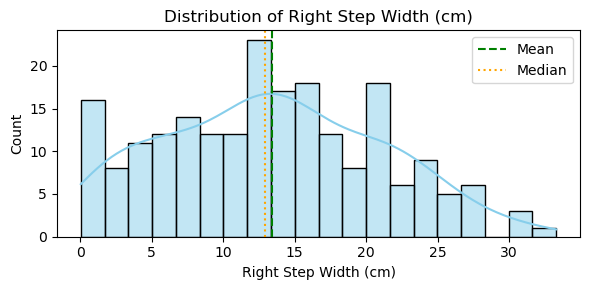


🧪 Left Step Width (cm)
  Mean: 6.553, Std: 4.651
  Outliers: 99 / 212 outside [5, 20]


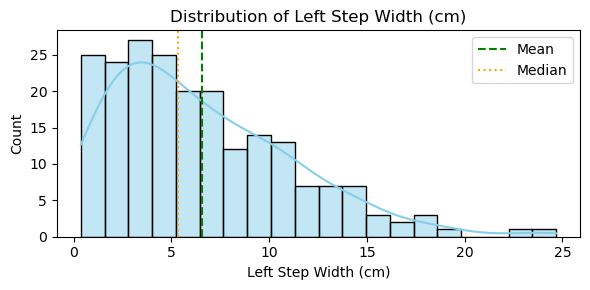


🧪 Right Stance Time (s)
  Mean: 0.541, Std: 0.013
  Outliers: 211 / 212 outside [0.6, 0.75]


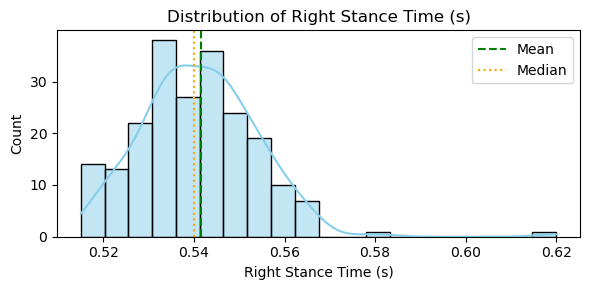


🧪 Left Stance Time (s)
  Mean: 0.528, Std: 0.011
  Outliers: 211 / 212 outside [0.6, 0.75]


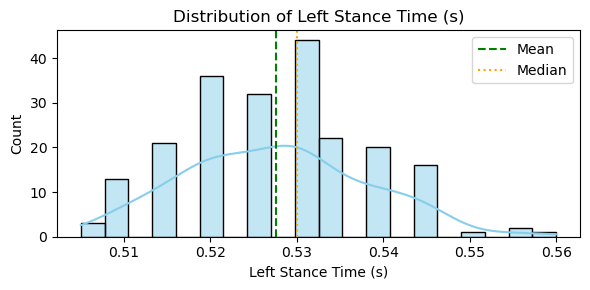


🧪 Right Swing Time (s)
  Mean: 0.585, Std: 0.008
  Outliers: 212 / 212 outside [0.4, 0.55]


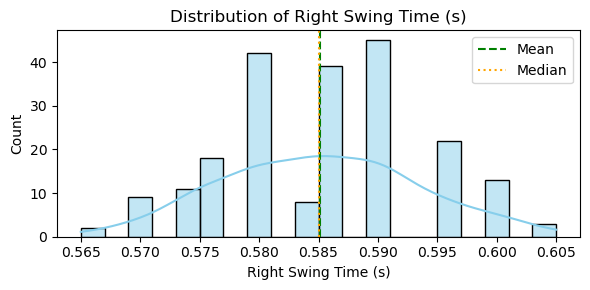


🧪 Left Swing Time (s)
  Mean: 0.599, Std: 0.009
  Outliers: 211 / 212 outside [0.4, 0.55]


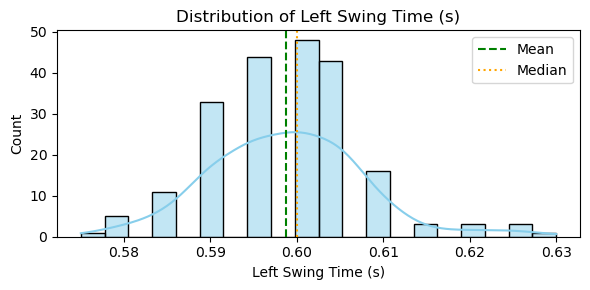

In [ ]:
#To validate the spatiotemporal data
# Create the DataFrame
df = pd.DataFrame(spatiotemporal_data)

# Define expected physiological ranges
expected_ranges = {
    "Right Step Width (cm)": (5, 20),
    "Left Step Width (cm)": (5, 20),
    "Right Stance Time (s)": (0.6, 0.75),
    "Left Stance Time (s)": (0.6, 0.75),
    "Right Swing Time (s)": (0.4, 0.55),
    "Left Swing Time (s)": (0.4, 0.55),
}

# Helper functions
def validate_variable(df, column, lower, upper):
    series = df[column]
    outliers = df[(series < lower) | (series > upper)]
    print(f"\n🧪 {column}")
    print(f"  Mean: {series.mean():.3f}, Std: {series.std():.3f}")
    print(f"  Outliers: {len(outliers)} / {len(series)} outside [{lower}, {upper}]")
    return outliers

def plot_variable(df, column):
    plt.figure(figsize=(6, 3))
    sns.histplot(df[column], kde=True, bins=20, color='skyblue')
    plt.axvline(df[column].mean(), color='green', linestyle='--', label='Mean')
    plt.axvline(df[column].median(), color='orange', linestyle=':', label='Median')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run validation
outliers_found = {}
for col, (low, high) in expected_ranges.items():
    outliers = validate_variable(df, col, low, high)
    outliers_found[col] = outliers
    plot_variable(df, col)



<h1><b>NONLINEAR ANALYSIS</b></h1>

In [6]:
#Select the variable for nonlinear analysis 
data1 = df['Knee Flexion RT (deg)']
#data1 = pd.DataFrame(data1) 
data1 = data1.values.flatten()  # Convert to 1D array

In [6]:
columna= df['Ankle Dorsiflexion RT (deg)']
columna.to_csv('Ankle Dorsiflexion RT (deg)', index=False)

In [7]:
#To identify The time lag that gives just the “right” amount of information about the system
#Calculate the Average Mutual Information (AMI) 
#AMI Measures linear/nonlinear dependencies among two variables: • As an estimate of the time lag
#one can use 1/4th of the period

sys.path.append(os.path.abspath("NONAN_Library_main/python"))
from AMI_Stergiou import AMI_Stergiou
L = 6000  # max lag to which AMI will be calculated
tau, v_AMI = AMI_Stergiou(data1, L, to_matlab=False, n_bins=10)
ami_df = pd.DataFrame(v_AMI)

In [136]:
print(tau)

[[3.10000000e+01 1.13000000e+02]
 [4.50000000e+01 6.93588029e-01]
 [7.20000000e+01 7.24600303e-01]
 [9.10000000e+01 7.40944788e-01]
 [1.20000000e+02 4.91901368e-01]
 [1.48000000e+02 7.02723454e-01]
 [1.70000000e+02 6.49434843e-01]
 [1.94000000e+02 5.77010582e-01]
 [2.84000000e+02 4.92863387e-01]
 [3.09000000e+02 5.53241345e-01]
 [3.59000000e+02 4.11842901e-01]
 [4.37000000e+02 3.50033296e-01]
 [5.20000000e+02 3.09829038e-01]
 [5.98000000e+02 3.51393135e-01]
 [6.78000000e+02 2.08731942e-01]
 [7.58000000e+02 1.91397648e-01]
 [8.39000000e+02 3.09650123e-01]
 [9.16000000e+02 1.38960917e-01]
 [9.97000000e+02 1.31945850e-01]
 [1.08200000e+03 2.88572397e-01]
 [1.08400000e+03 2.88459699e-01]
 [1.14800000e+03 1.01977844e-01]
 [1.20700000e+03 4.13594512e-01]
 [1.24000000e+03 1.06978947e-01]
 [1.31000000e+03 2.84476586e-01]
 [1.33500000e+03 2.47466839e-01]
 [1.38500000e+03 8.67448415e-02]
 [1.44600000e+03 3.19840676e-01]
 [1.48100000e+03 9.48186129e-02]
 [1.54900000e+03 2.64236361e-01]
 [1.588000

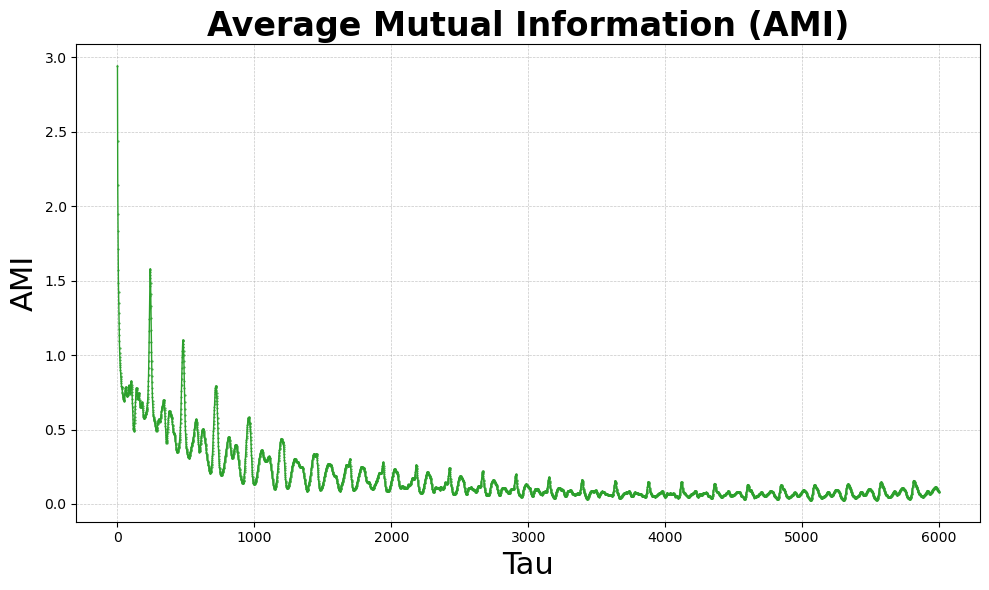

In [8]:
# Plot the AMI values
# Plot the AMI values
if not ami_df.empty:
    # Verifica que el DataFrame ami_df tenga al menos dos columnas
    if ami_df.shape[1] >= 2:
        # Extraer las columnas
        x_values = ami_df.iloc[0, :]  # Primera columna para el eje X
        y_values = ami_df.iloc[1, :]  # Segunda columna para el eje Y

        # Crear la gráfica
        plt.figure(figsize=(10, 6))

        # Usar un color personalizado y mejor estilo de línea
        plt.plot(x_values, y_values, label="AMI", color="#2ca02c", marker="o", markersize=0.5, linestyle='-', linewidth=1)

        # Mejorar la cuadrícula
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Agregar etiquetas y título con fuentes más grandes
        plt.title("Average Mutual Information (AMI)", fontsize=24, fontweight='bold')
        plt.xlabel("Tau", fontsize=22)
        plt.ylabel("AMI", fontsize=22)

        # Ajustar los márgenes y el layout
        plt.tight_layout()

        # Guardar la imagen en formato PNG
        plt.savefig('AMI.png', format='png')

        # Mostrar la gráfica
        plt.show()

else:
    print("El DataFrame ami_df está vacío. Asegúrate de que los valores de AMI se hayan calculado correctamente.")

In [9]:
tau=1000; # from the AMI 
#Determining embedding dimension using global false nearest neighbours FNN 
MaxDim =30;
Rtol =15;
Atol =2; 
speed =0; 
from FNN import FNN
[dim, dE] = FNN(data1,tau,MaxDim,Rtol,Atol,speed);
print("Embedding Dimension:", dE)

Embedding Dimension: 5


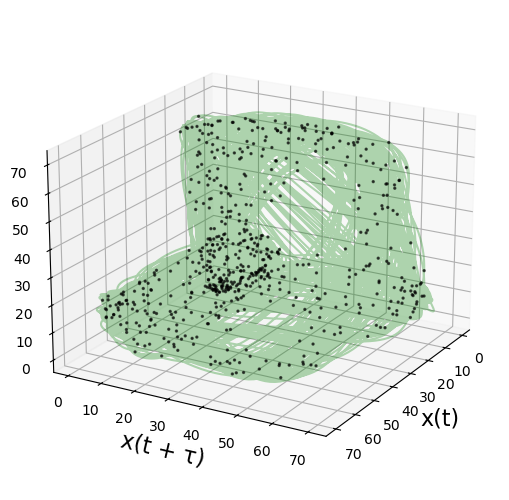

In [10]:
#State Space Reconstruction
numpoints = len(data1)
timelag = tau  
embeddingdimension = dE  
numsamples = numpoints - (embeddingdimension - 1) * timelag
stateSpace = np.zeros((embeddingdimension, numsamples))

# Fill in the state space matrix
for i in range(embeddingdimension):
    stateSpace[i, :] = data1[i * timelag : numsamples + i * timelag]

# Plot the reconstructed state space
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(stateSpace[0, :], stateSpace[1, :], stateSpace[2, :], 'g', linewidth=1.5, alpha=0.3)
sampling_factor = 70  # Cambia este valor según la densidad deseada
sampled_indices = np.arange(0, stateSpace.shape[1], sampling_factor)
ax.scatter(stateSpace[0, sampled_indices], stateSpace[1, sampled_indices], stateSpace[2, sampled_indices], 
           c='k', s=2, alpha=0.6)

# Add labels and title
#ax.set_title('Reconstructed Knee Flexion')
ax.set_xlabel('x(t)', fontsize=16)
ax.set_ylabel('x(t + τ)',fontsize=16)
ax.set_zlabel('x(t + 2τ)', labelpad=30, rotation=90, fontsize=16)
ax.grid(True)

ax.view_init(elev=20, azim=30)

# Set axis limits for zoom (adjust these values to focus on the divergence region)
#ax.set_xlim([min(stateSpace[0, :]) * 0.5, max(stateSpace[0, :]) * 0.5])
#ax.set_ylim([min(stateSpace[1, :]) * 0.5, max(stateSpace[1, :]) * 0.5])
#ax.set_zlim([min(stateSpace[2, :]) * 0.5, max(stateSpace[2, :]) * 0.5])

plt.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

#Show the divergence of the state space
# Calculate the distance between points in the state space

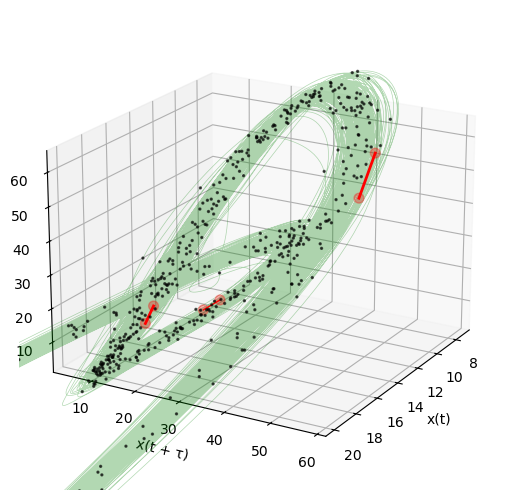

In [101]:
#To plot the LyE concept 
from LyE_W import LyE_W
evolve=int(5*sampling_rate) #number of sample intervals by which each pair of neighboring points is followed before a new neighboring pair is chosen.
data1=np.array(data1)
tau=30
dE=3
sampling_rate=200
out, LyE = LyE_W(data1,sampling_rate,tau,dE,evolve)
lyapunov_exp = LyE_W
# Crear una figura para la visualización 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Traza toda la trayectoria reconstruida
ax.plot(stateSpace[0, :], stateSpace[1, :], stateSpace[2, :], 'g', linewidth=0.5, alpha=0.3)
ax.scatter(stateSpace[0, sampled_indices], stateSpace[1, sampled_indices], stateSpace[2, sampled_indices], 
           c='k', s=2, alpha=0.6)

# Muestra los puntos cercanos en una instantánea
point_index = 505  # Ejemplo de índice de punto
neighbor_index = point_index + dim  # Este es el índice del vecino más cercano basado en tu cálculo

# Obtén los puntos
point1 = stateSpace[:, point_index]
point2 = stateSpace[:, neighbor_index]

# Conectar estos puntos con una línea roja en la visualización
ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], color='r', linewidth=1)

# Resalta la cercanía de los puntos
ax.scatter([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], c='r', s=50, alpha=0.3)

# Ahora seleccionamos 2 puntos más
point_index_2 = 615  # Índice de punto 2
neighbor_index_2 = point_index_2 + dim  # Índice del vecino más cercano para el segundo par

# Obtén los puntos 3 y 4
point3 = stateSpace[:, point_index_2]
point4 = stateSpace[:, neighbor_index_2]

# Conectar estos puntos con una línea roja en la visualización
ax.plot([point3[0], point4[0]], [point3[1], point4[1]], [point3[2], point4[2]], color='r', linewidth=2)
ax.scatter([point3[0], point4[0]], [point3[1], point4[1]], [point3[2], point4[2]], c='r', s=50, alpha=0.3)

# Ahora seleccionamos 2 puntos más
point_index_3 = 545  # Índice de punto 2
neighbor_index_3 = point_index_3 + dim  # Índice del vecino más cercano para el segundo par

# Obtén los puntos 3 y 4
point5 = stateSpace[:, point_index_3]
point6 = stateSpace[:, neighbor_index_3]

# Conectar estos puntos con una línea roja en la visualización
ax.plot([point5[0], point6[0]], [point5[1], point6[1]], [point5[2], point6[2]], color='r', linewidth=2)
ax.scatter([point5[0], point6[0]], [point5[1], point6[1]], [point5[2], point6[2]], c='r', s=50, alpha=0.3)



# Añadir etiquetas y título
#ax.set_title('Reconstructed Knee Flexion with Lyapunov Exponent Concept')
ax.set_xlabel('x(t)')
ax.set_ylabel('x(t + τ)')
ax.set_zlabel('x(t + 2τ)', labelpad=20, rotation=90)

# Ajustar límites de los ejes dinámicamente para enfocar los puntos seleccionados
padding = 5  # Añadir un pequeño margen alrededor de los puntos
x_min = min(point1[0], point2[0], point3[0], point4[0], point5[0], point6[0]) - padding
x_max = max(point1[0], point2[0], point3[0], point4[0], point5[0], point6[0]) + padding
y_min = min(point1[1], point2[1], point3[1], point4[1], point5[1], point6[1]) - padding
y_max = max(point1[1], point2[1], point3[1], point4[1], point5[1], point6[1]) + padding
z_min = min(point1[2], point2[2], point3[2], point4[2], point5[2], point6[2]) - padding
z_max = max(point1[2], point2[2], point3[2], point4[2], point5[2], point6[2]) + padding

# Establecer los límites de los ejes
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

# Ajustar la vista
ax.view_init(elev=20, azim=30)

# Ajustar el diseño para evitar recortes
plt.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Mostrar la gráfica
plt.show()

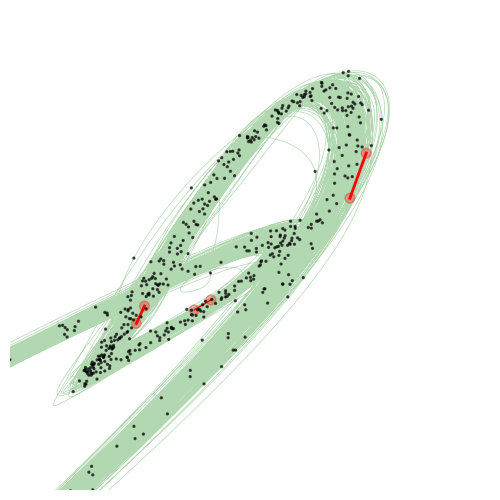

In [102]:
# To plot the LyE concept 
from LyE_W import LyE_W
evolve = int(5 * sampling_rate)  # Number of sample intervals by which each pair of neighboring points is followed before a new neighboring pair is chosen.
data1 = np.array(data1)
tau = 30
dE = 3
sampling_rate = 200
out, LyE = LyE_W(data1, sampling_rate, tau, dE, evolve)

# Crear una figura para la visualización 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Traza toda la trayectoria reconstruida
ax.plot(stateSpace[0, :], stateSpace[1, :], stateSpace[2, :], 'g', linewidth=0.5, alpha=0.3)
ax.scatter(stateSpace[0, sampled_indices], stateSpace[1, sampled_indices], stateSpace[2, sampled_indices], 
           c='k', s=2, alpha=0.6)

# Muestra los puntos cercanos en una instantánea
point_index = 505  # Ejemplo de índice de punto
neighbor_index = point_index + dim  # Este es el índice del vecino más cercano basado en tu cálculo

# Obtén los puntos
point1 = stateSpace[:, point_index]
point2 = stateSpace[:, neighbor_index]

# Conectar estos puntos con una línea roja en la visualización
ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], color='r', linewidth=1)

# Resalta la cercanía de los puntos
ax.scatter([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], c='r', s=50, alpha=0.3)

# Ahora seleccionamos 2 puntos más
point_index_2 = 615  # Índice de punto 2
neighbor_index_2 = point_index_2 + dim  # Índice del vecino más cercano para el segundo par

# Obtén los puntos 3 y 4
point3 = stateSpace[:, point_index_2]
point4 = stateSpace[:, neighbor_index_2]

# Conectar estos puntos con una línea roja en la visualización
ax.plot([point3[0], point4[0]], [point3[1], point4[1]], [point3[2], point4[2]], color='r', linewidth=2)
ax.scatter([point3[0], point4[0]], [point3[1], point4[1]], [point3[2], point4[2]], c='r', s=50, alpha=0.3)

# Ahora seleccionamos 2 puntos más
point_index_3 = 545  # Índice de punto 2
neighbor_index_3 = point_index_3 + dim  # Índice del vecino más cercano para el segundo par

# Obtén los puntos 5 y 6
point5 = stateSpace[:, point_index_3]
point6 = stateSpace[:, neighbor_index_3]

# Conectar estos puntos con una línea roja en la visualización
ax.plot([point5[0], point6[0]], [point5[1], point6[1]], [point5[2], point6[2]], color='r', linewidth=2)
ax.scatter([point5[0], point6[0]], [point5[1], point6[1]], [point5[2], point6[2]], c='r', s=50, alpha=0.3)

# Quitar los ejes y las leyendas
ax.set_axis_off()  # Esto oculta los ejes

# Establecer los límites de los ejes
padding = 5  # Añadir un pequeño margen alrededor de los puntos
x_min = min(point1[0], point2[0], point3[0], point4[0], point5[0], point6[0]) - padding
x_max = max(point1[0], point2[0], point3[0], point4[0], point5[0], point6[0]) + padding
y_min = min(point1[1], point2[1], point3[1], point4[1], point5[1], point6[1]) - padding
y_max = max(point1[1], point2[1], point3[1], point4[1], point5[1], point6[1]) + padding
z_min = min(point1[2], point2[2], point3[2], point4[2], point5[2], point6[2]) - padding
z_max = max(point1[2], point2[2], point3[2], point4[2], point5[2], point6[2]) + padding

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

# Ajustar la vista
ax.view_init(elev=20, azim=30)

# Ajustar el diseño para evitar recortes
plt.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Mostrar la gráfica
plt.show()


In [118]:
from LyE_W import LyE_W
evolve=int(5*sampling_rate) #number of sample intervals by which each pair of neighboring points is followed before a new neighboring pair is chosen.
LyE_results = []
taus = np.linspace(30, 6000, 10, dtype=int)
for tau in taus:
    out,LyE_v =LyE_W(data1,sampling_rate,tau,dE,evolve);
    LyE_results.append({"Tau": tau, "Lyapunov Exponent": LyE_v}) 

LyE_df = pd.DataFrame(LyE_results)

print(LyE_df)

/home/dmartinez/Documentos/Di_Inv/NONAN_Library_main/python/LyE_W.py:183: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cosTheta)


    Tau  Lyapunov Exponent
0    30           0.427839
1   693           0.170226
2  1356           0.192525
3  2020           0.119807
4  2683           0.070806
5  3346           0.182852
6  4010           0.121761
7  4673           0.114211
8  5336           0.087717
9  6000           0.233605


In [72]:
print(COd)

(0         3.411162
1         3.431896
2         3.453720
3         3.476662
4         3.498610
           ...    
47996    15.572315
47997    14.934370
47998    14.305664
47999    13.688440
48000    13.084995
Name: Knee Flexion LT (deg), Length: 48001, dtype: float64, 5, 5)
